# Support Vector Machines

In [139]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.datasets as ds
import sklearn.model_selection as cv
import sklearn.neighbors as nb
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    validation_curve,
    StratifiedShuffleSplit
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
)
from sklearn.svm import (
    LinearSVC,
    SVC,
)
from sklearn.ensemble import (
    ExtraTreesClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (
    mutual_info_classif,
    SelectKBest
)

import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

%matplotlib inline

Load data (standardized)

In [141]:
df = pd.read_csv(filepath_or_buffer="Dataset/Standardized_Smoking.csv")

x = df.iloc[:, :-1]
y = df.loc[:, "smoking"]

## Feature selection

We need to perform some kind of feature selection to reduce the cost of the SVM (irrelevant features may cause the model to struggle to find the optimum)

We will perform this feature selection by ranking the features.

Testing with 1 features...
Testing with 2 features...
Testing with 3 features...
Testing with 4 features...
Testing with 5 features...
Testing with 6 features...
Testing with 7 features...
Testing with 8 features...
Testing with 9 features...
Testing with 10 features...
Testing with 11 features...
Testing with 12 features...
Testing with 13 features...
Testing with 14 features...
Testing with 15 features...
Testing with 16 features...
Testing with 17 features...
Testing with 18 features...
Testing with 19 features...
Testing with 20 features...
Testing with 21 features...
Testing with 22 features...
Testing with 23 features...
Testing with 24 features...


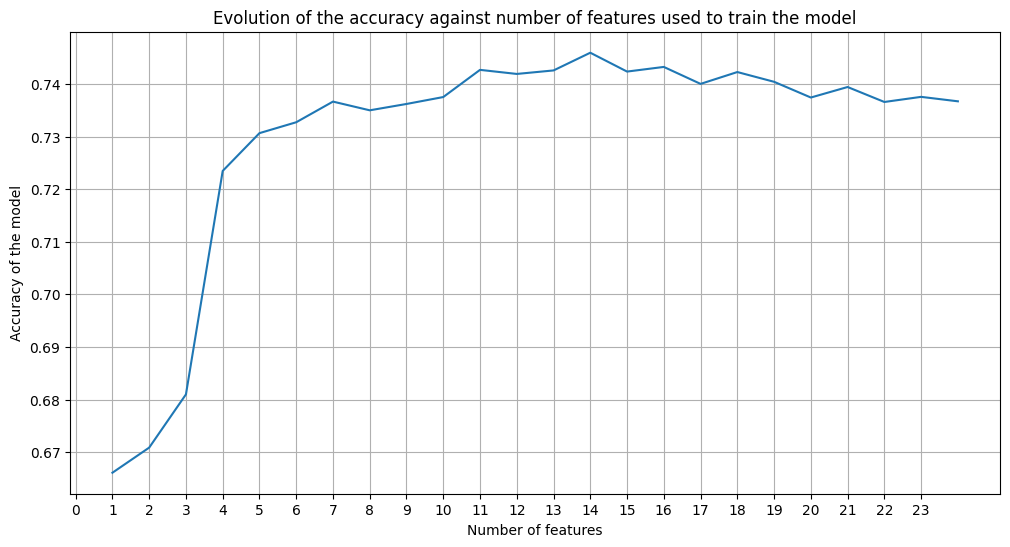

In [142]:
n_features = x.shape[1]
original = np.zeros(n_features)
for i in range(n_features):
    print(f"Testing with {i+1} features...")
    X_reduced = SelectKBest(mutual_info_classif, k=i+1).fit_transform(x, y)
    cvkf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_scores = cross_val_score(nb.KNeighborsClassifier(), X=X_reduced,y=y, cv=cvkf, scoring='accuracy')
    original[i]=np.mean(cv_scores)

fig = plt.figure(figsize = (12, 6))  # Just declare the figure object and give dimensions
plt.grid(True)
plt.title("Evolution of the accuracy against number of features used to train the model")
plt.ylabel("Accuracy of the model")
plt.xlabel("Number of features")
plt.xticks(np.arange(0, n_features, step=1))
plt.plot(range(1,n_features+1), original)
plt.show()

We select 7 features, as it provides a good balance between amount of information vs dimensionality.

In [143]:
# Testing outcome better without feature selection
# x = SelectKBest(mutual_info_classif, k=7).fit_transform(x, y)

# Linear SVM

In [144]:
(X_train, X_test,  y_train, y_test) = cv.train_test_split(x, y, test_size = .3, stratify = y, random_state = 1) # Reduce greatly amount of training data
sampler = RandomUnderSampler(sampling_strategy='majority', random_state=1)
X_train, y_train = sampler.fit_resample(X_train, y_train) # Compensate for data unbalance

print(f"Amount of training examples: {X_train.shape[0]}")
print(f"Amount of evaluation examples: {X_test.shape[0]}")

Amount of training examples: 28542
Amount of evaluation examples: 16649


Fitting 10 folds for each of 17 candidates, totalling 170 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CPU times: user 19 s, sys: 1.98 s, total: 21 s
Wall time: 14min 35s


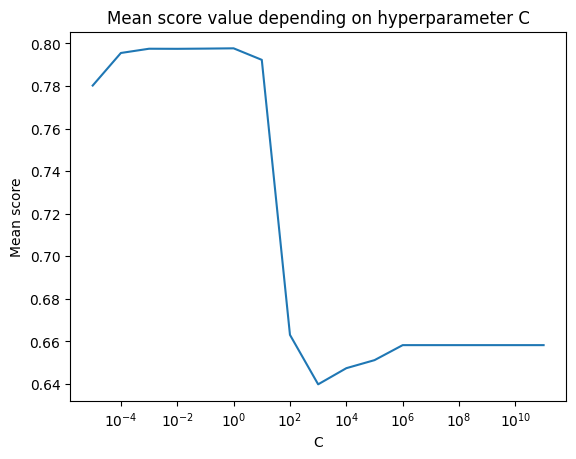

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

f1 score 10-fold cross on train data = 0.7982900154072033

Confusion matrix on test set:
 [[6305 4227]
 [ 396 5721]]

Accuracy on test set: 0.7223256652051174
f1 on test set: 0.7122315592903827

Best value of parameter C found: {'C': 1.0}

Number of supports: 15541 (12749 of them have slacks)
Prop. of supports: 0.5444958307056268


In [145]:
# List of C values to test. We usualy test diverse orders of magnitude
Cs = np.logspace(-5, 11, num=17, base=10.0)


param_grid = {"C": Cs}
cvss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
#grid_search = GridSearchCV(LinearSVC(), param_grid, cv=10)
grid_search = GridSearchCV(
    LinearSVC(random_state=1),
    param_grid,
    cv = cvss,
    verbose=10,
    n_jobs=-1,
    scoring = "f1"
)
%time grid_search.fit(X_train, y_train)

# Let's plot the 10-fold cross.validation accuracy deppending on C
scores = grid_search.cv_results_["mean_test_score"]
plt.title("Mean score value depending on hyperparameter C")
plt.xlabel("C")
plt.ylabel("Mean score")
plt.semilogx(Cs,scores)
plt.show()

parval=grid_search.best_params_
cvacc = cross_val_score(
    LinearSVC(C = parval["C"]),
    X = X_train,
    y = y_train,
    cv = 10,
    scoring = "f1"
)
print(f"f1 score 10-fold cross on train data = {cvacc.mean()}")

# Let's apply the best C parameter found to the test set
knc = SVC(C=parval['C'])
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

print(f"\nConfusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"f1 on test set: {sklearn.metrics.f1_score(y_test, prediction)}")
print(f"\nBest value of parameter C found: {parval}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")

# Polynomial kernel


In [146]:
(X_train, X_test,  y_train, y_test) = cv.train_test_split(x, y, train_size=.15, test_size = .3, stratify = y, random_state = 1) # Reduce greatly amount of training data
sampler = RandomUnderSampler(sampling_strategy='majority', random_state=1)
X_train, y_train = sampler.fit_resample(X_train, y_train) # Compensate for data unbalance

print(f"Amount of training examples: {X_train.shape[0]}")
print(f"Amount of evaluation examples: {X_test.shape[0]}")

Amount of training examples: 6116
Amount of evaluation examples: 16649


In [147]:
knc = SVC(
    kernel = "poly",
    degree = 2
)
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

print(f"Confusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")

Confusion matrix on test set:
 [[5916 4616]
 [ 321 5796]]

Accuracy on test set: 0.7034656736140309


Fitting 10 folds for each of 5 candidates, totalling 50 fits


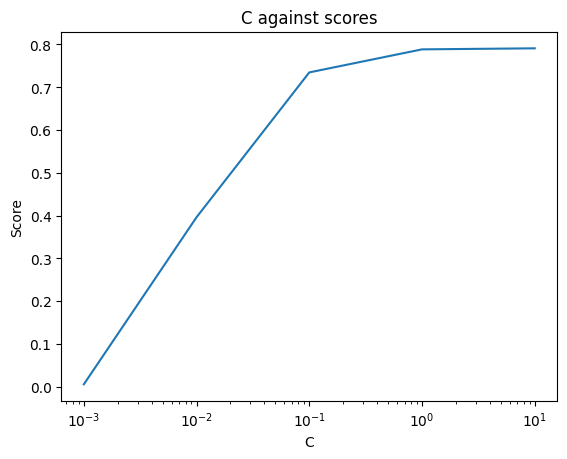

f1 10-fold cross on train data=  0.79100721756747

Confusion matrix on test set:
 [[5854 4678]
 [ 275 5842]]

Accuracy on test set: 0.7025046549342303
f1 on test set: 0.7022900763358779

Best combination of parameters found: {'C': 10.0}

Number of supports: 3351 (3031 of them have slacks)
Prop. of supports: 0.5479071288423807


In [148]:
Cs = np.logspace(-3, 1, num = 5, base = 10.0)

param_grid = {"C": Cs}
grid_search = GridSearchCV(
    SVC(kernel = "poly",degree = 2) ,
    param_grid,
    cv = 10,
    verbose=10,
    n_jobs=-1,
    scoring="f1"
)
grid_search.fit(X_train,y_train)

scores = grid_search.cv_results_['mean_test_score']

plt.semilogx(Cs, scores)
plt.title("C against scores")
plt.xlabel("C")
plt.ylabel("Score")
plt.show()

parval = grid_search.best_params_

cvacc = cross_val_score(SVC(kernel='poly',degree =2,C=parval['C']) , X=X_train,  y=y_train, cv=10, scoring='f1')
print('f1 10-fold cross on train data= ', cvacc.mean())


knc = SVC(kernel='poly',degree =2, C=parval['C'])
knc.fit(X_train, y_train)
prediction =knc.predict(X_test)
print(f"\nConfusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"f1 on test set: {sklearn.metrics.f1_score(y_test, prediction)}")
print(f"\nBest combination of parameters found: {parval}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")

Now with degreee 3

Fitting 10 folds for each of 5 candidates, totalling 50 fits


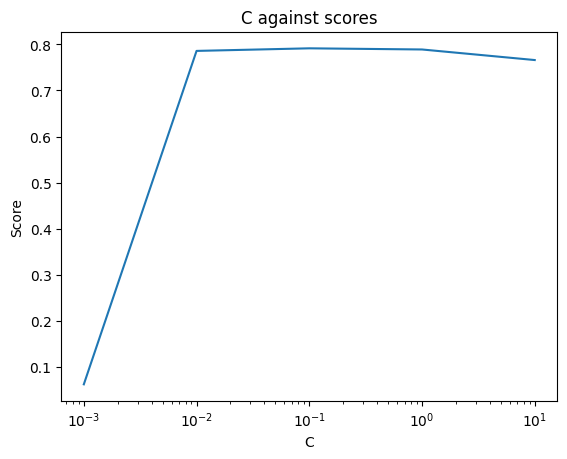

f1 10-fold cross on train data=  0.7914713486268743

Confusion matrix on test set:
 [[5910 4622]
 [ 315 5802]]

Accuracy on test set: 0.7034656736140309
f1 on test set: 0.70152953267638

Best combination of parameters found: {'C': 0.1}

Number of supports: 4471 (4244 of them have slacks)
Prop. of supports: 0.7310333551340745


In [149]:
Cs = np.logspace(-3, 1, num = 5, base = 10.0)

param_grid = {"C": Cs}
grid_search = GridSearchCV(
    SVC(kernel = "poly",degree = 3) ,
    param_grid,
    cv = 10,
    verbose=10,
    n_jobs=-1,
    scoring="f1"
)
grid_search.fit(X_train,y_train)

scores = grid_search.cv_results_['mean_test_score']

plt.semilogx(Cs, scores)
plt.title("C against scores")
plt.xlabel("C")
plt.ylabel("Score")
plt.show()

parval = grid_search.best_params_

cvacc = cross_val_score(SVC(kernel='poly',degree =3,C=parval['C']) , X=X_train,  y=y_train, cv=10, scoring='f1')
print('f1 10-fold cross on train data= ', cvacc.mean())


knc = SVC(kernel='poly',degree =3, C=parval['C'])
knc.fit(X_train, y_train)
prediction =knc.predict(X_test)
print(f"\nConfusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"f1 on test set: {sklearn.metrics.f1_score(y_test, prediction)}")
print(f"\nBest combination of parameters found: {parval}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")

# RBF Kernel

Low number of examples test run to find best parameters

In [150]:
(X_train, X_test,  y_train, y_test) = cv.train_test_split(x, y, train_size=.02, test_size = .3, stratify = y, random_state = 1) # Reduce greatly amount of training data
sampler = RandomUnderSampler(sampling_strategy='majority', random_state=1)
X_train, y_train = sampler.fit_resample(X_train, y_train) # Compensate for data unbalance

print(f"Amount of training examples: {X_train.shape[0]}")
print(f"Amount of evaluation examples: {X_test.shape[0]}")

Amount of training examples: 814
Amount of evaluation examples: 16649


In [151]:
knc = SVC()
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)
print(f"Confusion matrix on test set:\n{sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")

Confusion matrix on test set:
[[6318 4214]
 [ 603 5514]]

Accuracy on test set: 0.7106733137125353


Fitting 10 folds for each of 64 candidates, totalling 640 fits


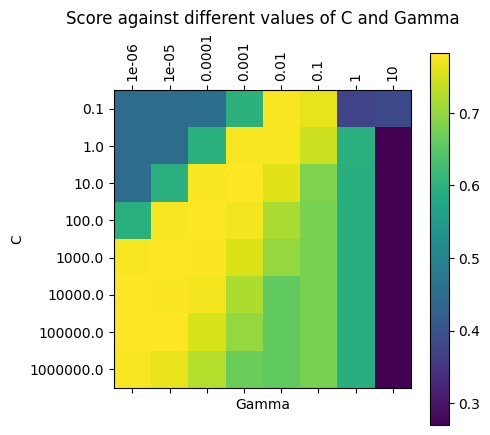


Best combination of parameters found: {'C': 10.0, 'gamma': 0.001}

f1 score 10-fold cross on train data = 0.7826305789744702


In [152]:
# Values we will test for each parameter. When observin results, consider the limits of the
# values tested and increase them if necessary
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
Cs = np.logspace(-1, 6, num = 8, base = 10.0)

param_grid = {
    "C": Cs,
    "gamma" : gammas
}
grid_search = GridSearchCV(
    SVC(),
    param_grid,
    cv = 10,
    verbose=10,
    n_jobs=-1,
    scoring="f1"
)
grid_search.fit(X_train,y_train)
parval = grid_search.best_params_

# We'll show in a grid, the accuracy for each combination of parameters tester
scores = grid_search.cv_results_["mean_test_score"]
scores = np.array(scores).reshape(  # In order to have it "grid-shaped"
    len(param_grid['C']),
    len(param_grid['gamma'])
)

plt.matshow(scores)
plt.title("Score against different values of C and Gamma")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(
    np.arange(len(param_grid["gamma"])),
    param_grid["gamma"],
    rotation = "vertical"
)
plt.yticks(
    np.arange(len(param_grid["C"])),
    param_grid["C"]
)
plt.show()
parval = grid_search.best_params_
print(f"\nBest combination of parameters found: {parval}")


cvacc = cross_val_score(
    SVC(
        C = parval["C"],
        gamma = parval["gamma"]
    ),
    X = X_train,
    y = y_train,
    cv = 10,
    scoring = "f1"
)
print(f'\nf1 score 10-fold cross on train data = {cvacc.mean()}')

In [153]:
(X_train, X_test,  y_train, y_test) = cv.train_test_split(x, y, test_size = .3, stratify = y, random_state = 1)
sampler = RandomUnderSampler(sampling_strategy='majority', random_state=1)
X_train, y_train = sampler.fit_resample(X_train, y_train) # Compensate for data unbalance

print(f"Amount of training examples: {X_train.shape[0]}")
print(f"Amount of evaluation examples: {X_test.shape[0]}")

Amount of training examples: 28542
Amount of evaluation examples: 16649


In [154]:
# Let's apply the best combination of parameters found to the test set
knc = SVC(
    C = parval["C"],
    gamma = parval["gamma"]
)
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

print(f"Confusion matrix on test set:\n{sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"f1 score on test set: {sklearn.metrics.f1_score(y_test, prediction)}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==parval['C'])} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")

Confusion matrix on test set:
[[5817 4715]
 [ 250 5867]]

Accuracy on test set: 0.7017838909243799
f1 score on test set: 0.7026768069944308

Number of supports: 14301 (13708 of them have slacks)
Prop. of supports: 0.5010510826150936


# Main support analysis



In [155]:
# Train the best combination found (without undersampling)
(X_train, X_test,  y_train, y_test) = cv.train_test_split(x, y, test_size = .3, stratify = y, random_state = 1) # Reduce greatly amount of training data
sampler = RandomUnderSampler(sampling_strategy='majority', random_state=1)
X_train, y_train = sampler.fit_resample(X_train, y_train) # Compensate for data unbalance

print(f"Amount of training examples: {X_train.shape[0]}")
print(f"Amount of evaluation examples: {X_test.shape[0]}")

knc = SVC(kernel='linear', C=1.0)
knc.fit(X_train, y_train)
prediction = knc.predict(X_test)

print(f"\nConfusion matrix on test set:\n {sklearn.metrics.confusion_matrix(y_test, prediction)}")
print(f"\nAccuracy on test set: {sklearn.metrics.accuracy_score(y_test, prediction)}")
print(f"f1 on test set: {sklearn.metrics.f1_score(y_test, prediction)}")
print(f"\nNumber of supports: {np.sum(knc.n_support_)} ({np.sum(np.abs(knc.dual_coef_)==1.0)} of them have slacks)")
print(f"Prop. of supports: {np.sum(knc.n_support_)/X_train.shape[0]}")

Amount of training examples: 28542
Amount of evaluation examples: 16649

Confusion matrix on test set:
 [[5815 4717]
 [ 249 5868]]

Accuracy on test set: 0.7017238272568923
f1 on test set: 0.702670338881571

Number of supports: 15674 (12603 of them have slacks)
Prop. of supports: 0.5491556302992082


In [156]:
decision_function = knc.decision_function(X_train)

In [157]:
support_vector_indices = knc.support_
slack_mask = knc.dual_coef_[0] == 1.0
slack_support_vector_indices = knc.support_[slack_mask]

In [158]:
support_vectors = X_train.iloc[support_vector_indices]
slack_support_vectors = X_train.iloc[slack_support_vector_indices]

In [159]:
support_vectors.describe()

,gender,age,height,weight,waist,sightL,sightR,hearL,hearR,systolicP,...,hdl,ldl,hemoglobin,uProtein,sCreatinine,ast,alt,gtp,caries,tartar
count,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,...,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000,15674.000000
mean,0.542627,-0.131540,0.366928,0.282726,0.200816,0.081993,0.093550,0.032558,0.027859,0.087561,...,-0.134334,-0.001561,0.318859,0.024039,0.312600,0.047510,0.087583,0.018224,0.025003,-0.008443
std,0.632818,1.055363,0.821143,0.917536,0.915687,0.985882,0.983989,1.093517,1.079757,0.958650,...,0.934757,0.975836,0.792892,1.052209,0.893155,0.960806,0.997539,0.772526,1.017056,1.000942
min,-1.319926,-2.003179,-3.224930,-2.797504,-3.131356,-2.753149,-2.750418,-0.161170,-0.162810,-3.618932,...,-3.615065,-3.212686,-6.147076,-0.215324,-3.605203,-1.041174,-0.840187,-0.773748,-0.521015,-1.118320
25%,0.757618,-0.758913,0.037349,-0.457567,-0.413794,-0.607480,-0.594233,-0.161170,-0.162810,-0.547109,...,-0.766232,-0.672695,-0.078133,-0.215324,-0.392210,-0.318919,-0.323888,-0.396093,-0.521015,-1.118320
50%,0.757618,-0.344157,0.581062,0.322412,0.211677,0.005568,0.021820,-0.161170,-0.162810,0.038001,...,-0.291426,-0.045168,0.432936,-0.215324,0.525789,-0.112561,-0.130275,-0.197327,-0.521015,0.894199
75%,0.757618,0.485354,1.124775,0.712402,0.750875,0.618616,0.637872,-0.161170,-0.162810,0.623110,...,0.319038,0.612241,0.816238,-0.215324,0.984788,0.196976,0.224681,0.140575,-0.521015,0.894199
max,0.757618,3.388642,2.755915,5.002286,4.956626,3.070809,3.102084,6.204636,6.142129,7.205589,...,6.627168,6.080692,2.796629,12.174946,41.835708,54.881930,51.144750,12.921220,1.919330,0.894199


In [160]:
decision_function

array([-1.00011402, -1.000093  ,  0.99997578, ...,  1.00007215,
        0.99996368,  0.99997386])

<ipython-input-161-9c9fdebecf03>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


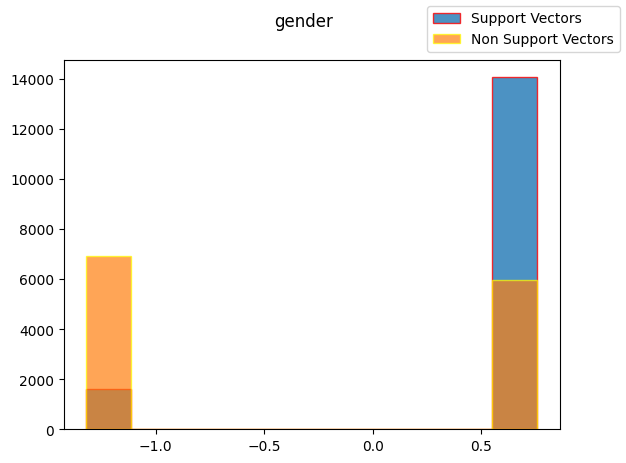

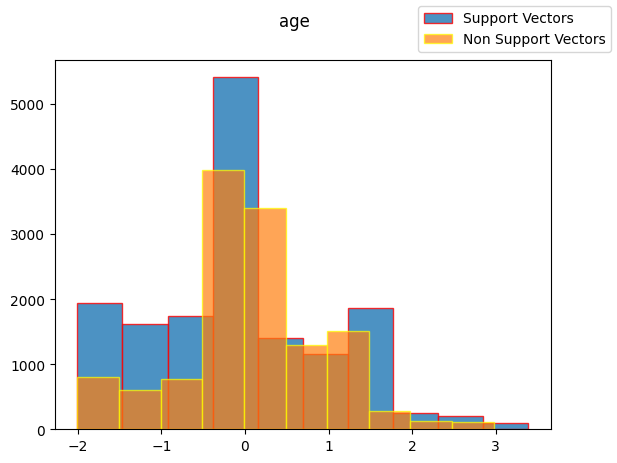

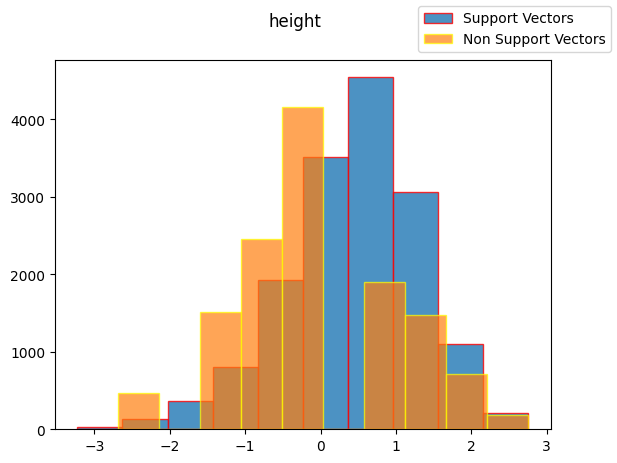

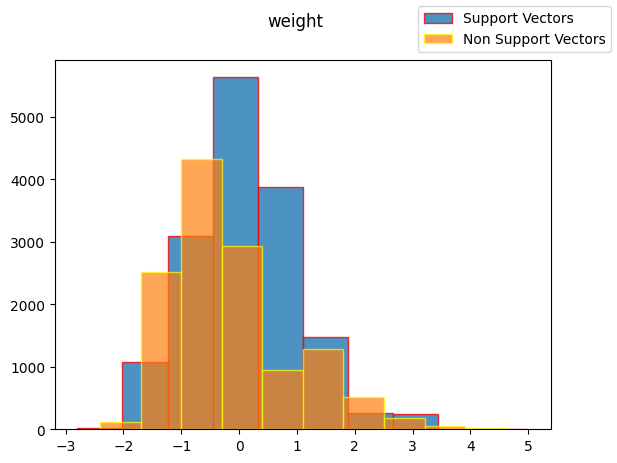

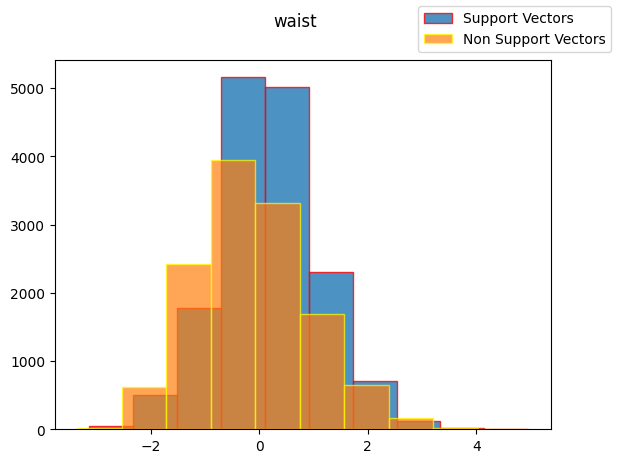

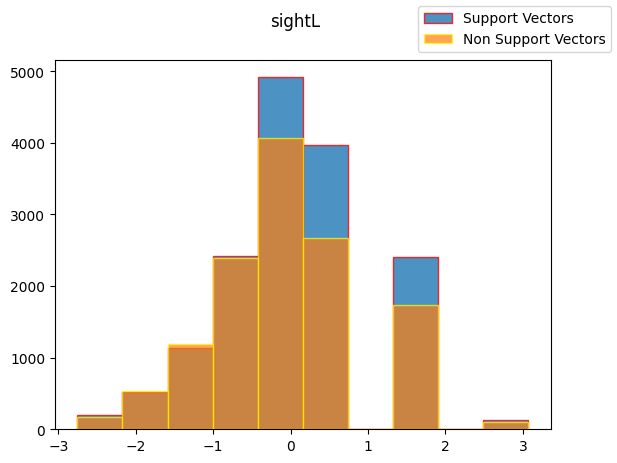

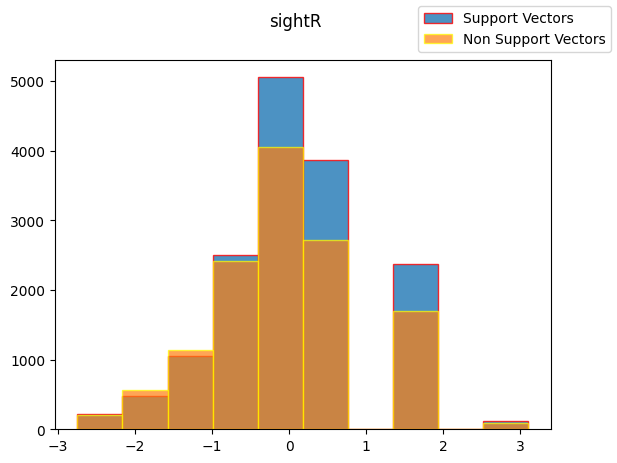

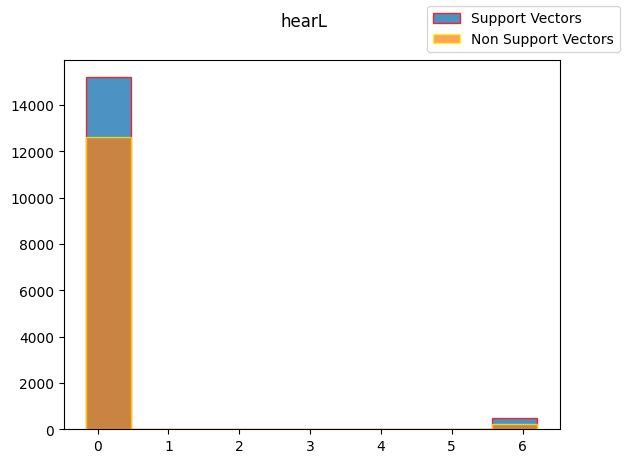

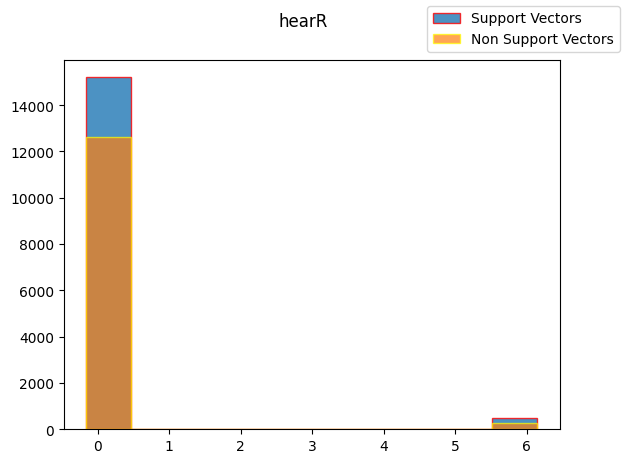

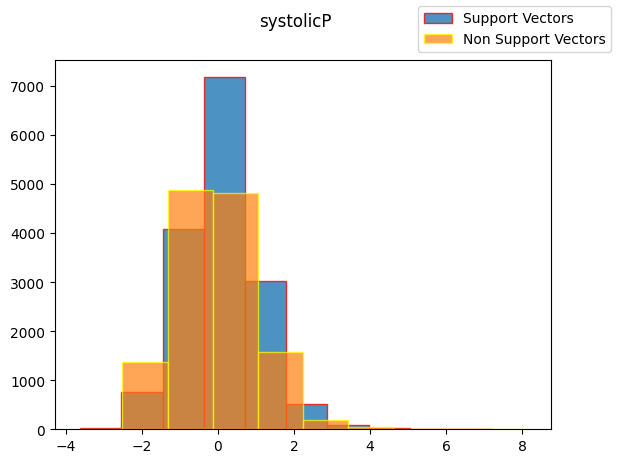

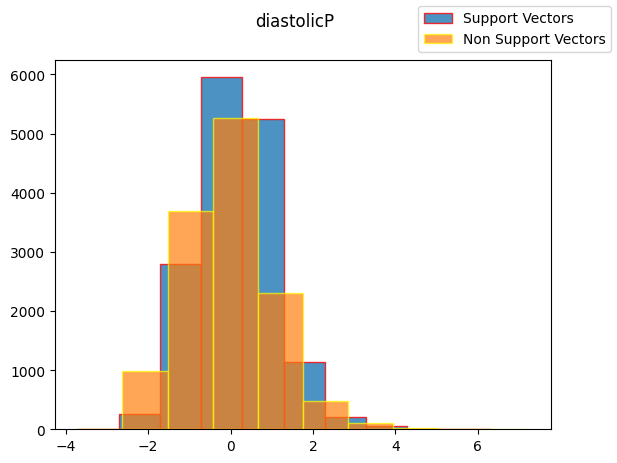

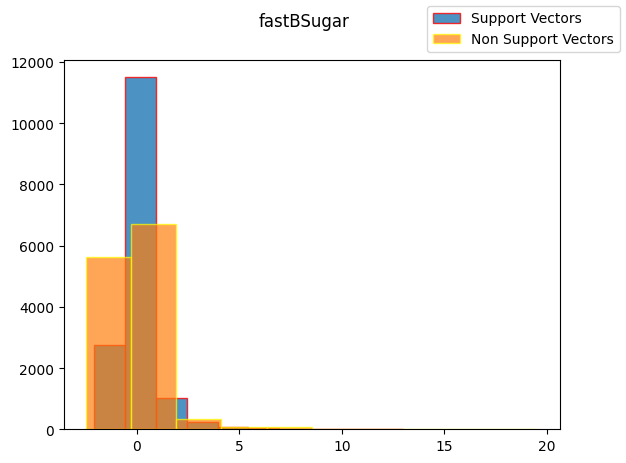

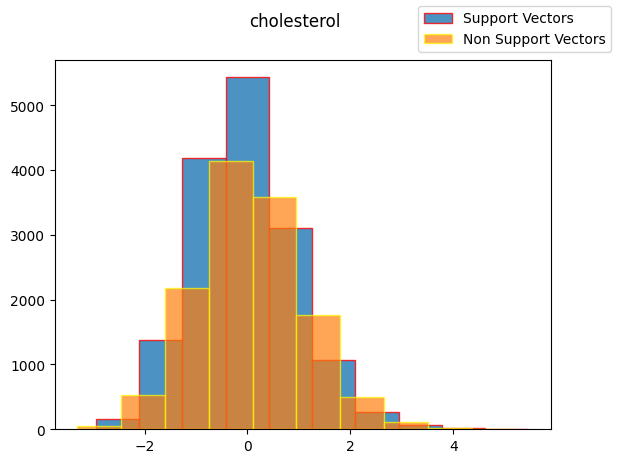

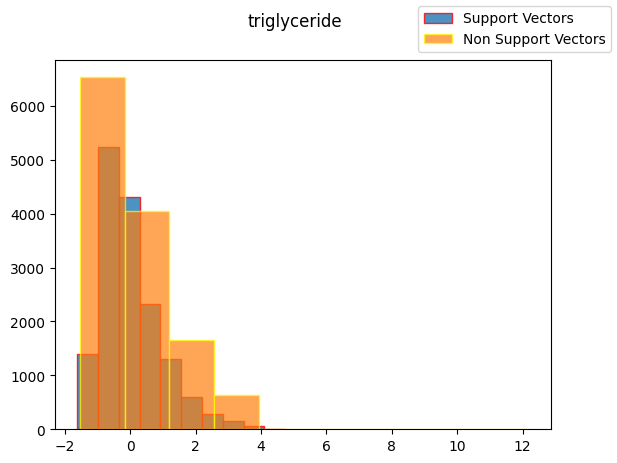

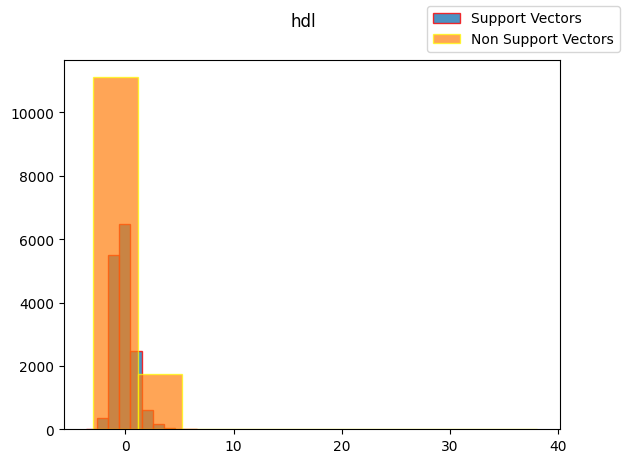

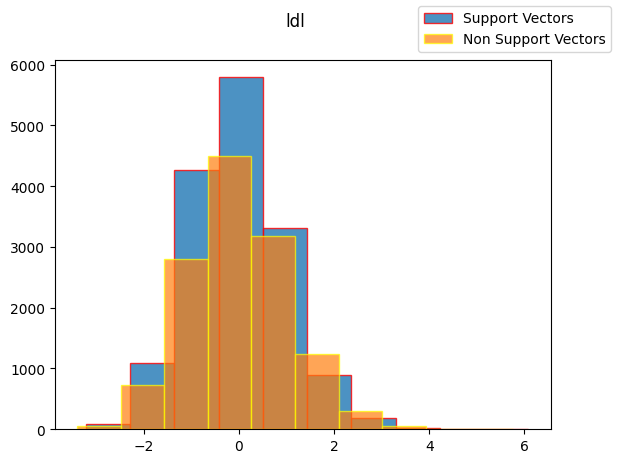

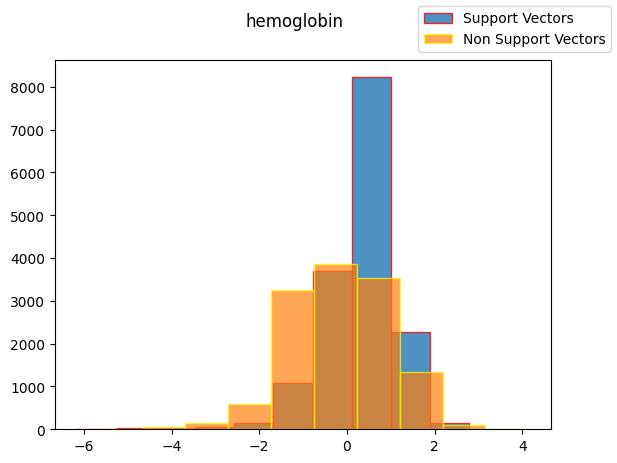

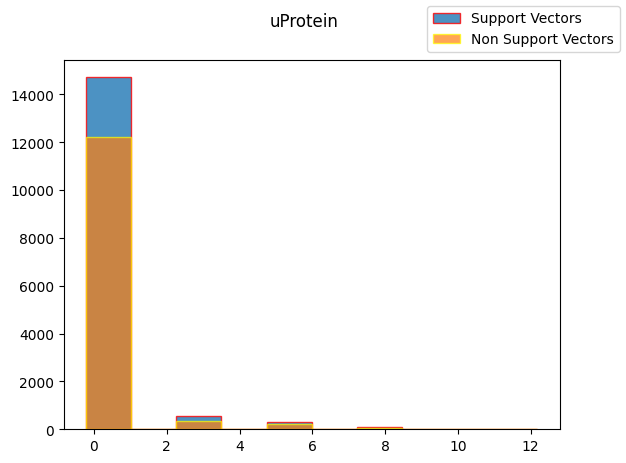

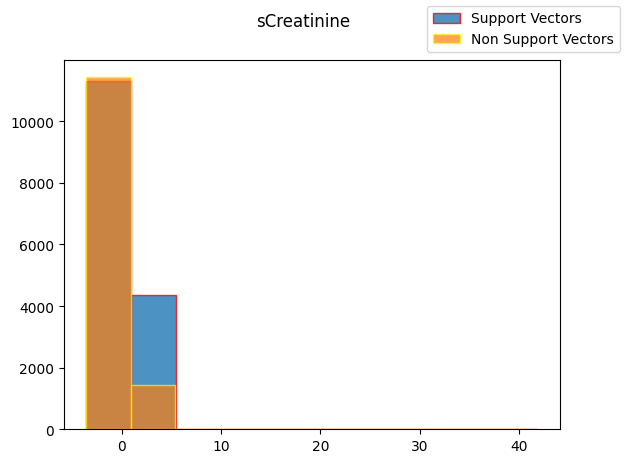

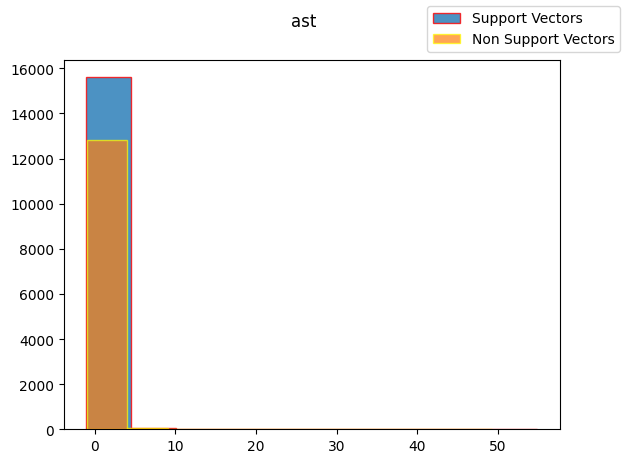

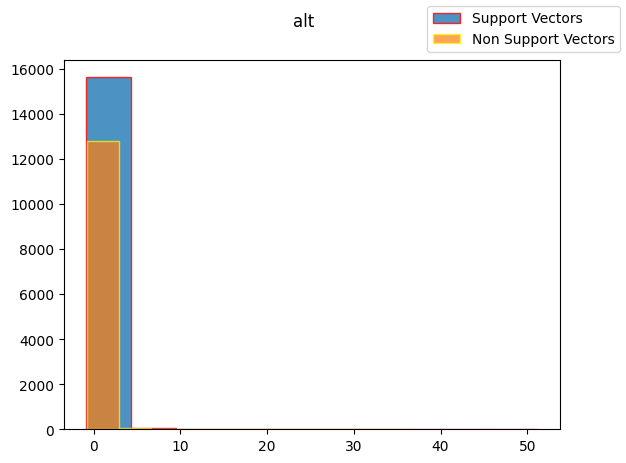

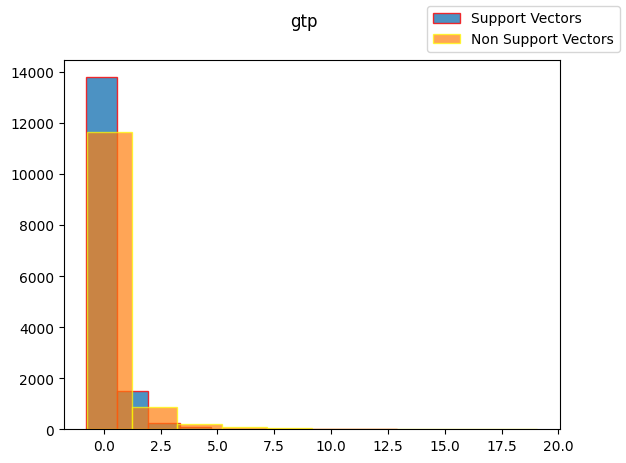

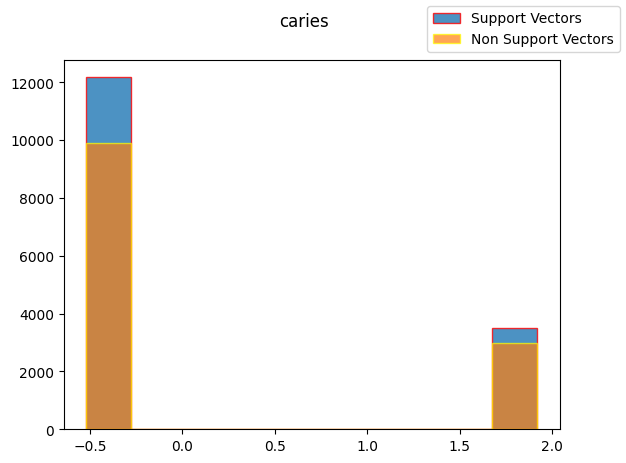

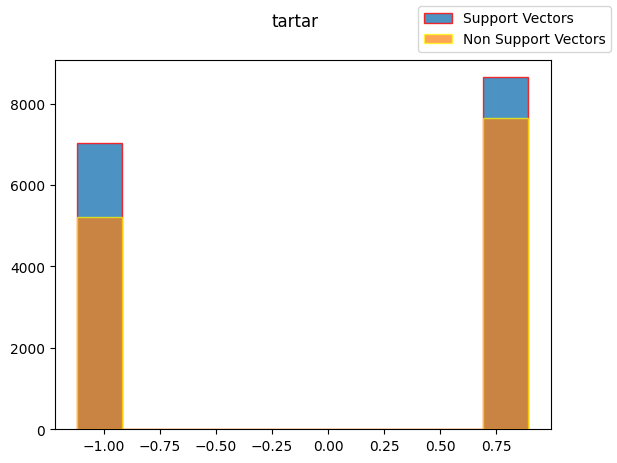

In [161]:
non_supp_vectors = X_train.drop(support_vector_indices)

for i in X_train.columns:
    fig, ax = plt.subplots(1, 1)
    fig.suptitle(i)
    ax.hist(support_vectors[i], label='Support Vectors', alpha=.8, edgecolor='red')
    ax.hist(non_supp_vectors[i], label='Non Support Vectors', alpha=0.7, edgecolor='yellow')
    fig.legend()